In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

## Removing Images' Backgrounds

In [3]:
%%skip

from tqdm import tqdm
import cv2
import scipy as scp
import numpy as np

# Extracting height and width information from entire dataset for later processing
dimensions = {'height': [], 'width': []}
for index, value in tqdm(ind_df['image_path'].dropna().items(), total=len(ind_df['image_path'].dropna()), desc='Reading images'):
    try:
        image = cv2.imread(value)
        dimensions['height'].append(image.shape[0])
        dimensions['width'].append(image.shape[1])
    except:
        print('\nCorrupted image: {}\n'.format(value))

print('''\nStatistics on height of images: \n{}
quantiles (0.25, 0.50, 0.75, 0.90) = {}, {}, {}, {}'''.format(scp.stats.describe(dimensions['height']), \
                                                              np.quantile(dimensions['height'], 0.25), \
                                                              np.quantile(dimensions['height'], 0.50), \
                                                              np.quantile(dimensions['height'], 0.75), \
                                                              np.quantile(dimensions['height'], 0.90)))
print('''\nStatistics on width of images: \n{}
quantiles (0.25, 0.50, 0.75, 0.90) = {}, {}, {}, {}'''.format(scp.stats.describe(dimensions['width']), \
                                                              np.quantile(dimensions['width'], 0.25), \
                                                              np.quantile(dimensions['width'], 0.50), \
                                                              np.quantile(dimensions['width'], 0.75), \
                                                              np.quantile(dimensions['width'], 0.90)))

In [4]:
# Importing libraries from previous cell and defining studied quantile values 
# for height and width so we don't keep recomputing them

from tqdm import tqdm
import cv2
import scipy as scp
import numpy as np

image_size = (640, 640)

In [5]:
from PIL import Image
import torch
from torchvision import transforms
from transformers import pipeline, AutoModelForImageSegmentation

# Reading first image
first_image = Image.open(ind_df['image_path'].loc[55663])

# Getting CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Removing backgroung 1
# Loading entire pipeline on CUDA device and processing image
seg_pipe = pipeline('image-segmentation', model='briaai/RMBG-1.4', trust_remote_code=True, device=device)
pillow_image = seg_pipe(first_image)
pillow_image.save("first_image_br_1.png")

# Removing background 2
# Loading model on CUDA device
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# Transforming images
# image_size = (int(np.quantile(dimensions['width'], 0.75)), int(np.quantile(dimensions['height'], 0.75)))
transform_image = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_images = transform_image(first_image).unsqueeze(0).to(device)

# Using model to predict background and saving image without background
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(first_image.size)
first_image.putalpha(mask)
first_image.save("first_image_br_2.png")

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


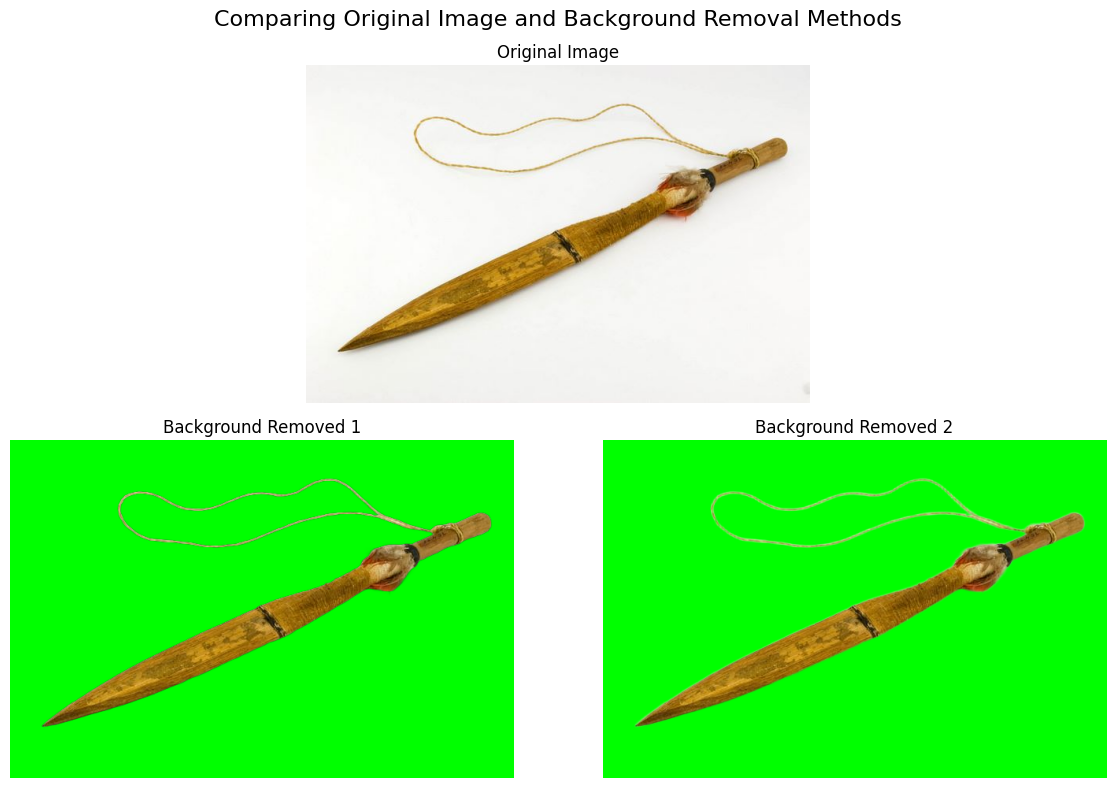

In [6]:
import matplotlib.pyplot as plt

# Visualizing first image and its background removal versions
first_image = Image.open(ind_df['image_path'].loc[55663])
first_image_br_1 = Image.open('first_image_br_1.png')
first_image_br_2 = Image.open('first_image_br_2.png').convert('RGBA')

# Creating green backgrounds for better background removal visualization
green_bg = Image.new("RGBA", first_image.size, (0, 255, 0, 255))
composite_1 = Image.alpha_composite(green_bg, first_image_br_1)
composite_2 = Image.alpha_composite(green_bg, first_image_br_2)

fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparing Original Image and Background Removal Methods', \
             fontsize=16)

ax1 = fig.add_subplot(2, 2, (1, 2))
ax1.imshow(first_image)
ax1.set_title("Original Image")
ax1.axis('off')

ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(composite_1)
ax2.set_title("Background Removed 1")
ax2.axis('off')

ax3 = fig.add_subplot(2, 2, 4)
ax3.imshow(composite_2)
ax3.set_title("Background Removed 2")
ax3.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Removing RMBG-1.4 from memory for space
del seg_pipe
torch.cuda.empty_cache()

In [8]:
# Splitting work in phases because of RAM/GPU-Memory issues
num_phases = 50
chunk_size = len(ind_df['image_path'].dropna()) // num_phases
filt_ind_df = ind_df[ind_df['image_path'].notna()]
final_predictions = []
for phase in range(num_phases):
    start_ind = phase*chunk_size

    # Big last phase to include remainder of the dataset
    if phase == num_phases-1:
        end_ind = len(ind_df['image_path'].dropna())
    else:
        end_ind = start_ind+chunk_size

    filt_ind_df_chunk = filt_ind_df.iloc[start_ind:end_ind]

    # Creating batches of images
    batch_size = 4
    image_batches = []
    batches = []
    for i, (index, value) in enumerate(tqdm(filt_ind_df_chunk['image_path'].items(), \
                                            total=len(filt_ind_df_chunk), \
                                            desc=f'Creating batches (phase {phase+1})')):
        # Reseting batches
        if i % batch_size == 0:
            if i > 0:
                batches.append(torch.stack(batch))
                image_batches.append(image_batch)
            image_batch = {}
            batch = []
    
        try:
            # Reading, transforming and appending images
            image = Image.open(value)
            image_batch[value] = image
            batch.append(transform_image(image))
        
        except:
            print('\n(Creating batches) corrupted image: {}\n'.format(value))
    
    # Adding last (possibly incomplete) batch
    if len(batch) != 0:
        batches.append(torch.stack(batch))
        image_batches.append(image_batch)
    
    # Removing background of all images using RMBG-2.0
    for image_batch, batch in tqdm(zip(image_batches, batches), total=len(batches), \
                                   desc='Removing backgrounds'):
        try:
            # Making predictions for batch
            with torch.no_grad():
                preds = model(batch.to(device))[-1].sigmoid().cpu()
            preds = preds.squeeze(1)

            # Removing background of original images individually
            for pred, (path, image) in zip(preds, image_batch.items()):
                pred_pil = transforms.ToPILImage()(pred)
                mask = pred_pil.resize(image.size)
                image.putalpha(mask)
                
                image_number = path.split('/')[-1].split('.')[0]
                image.save(f'data/br_images/{image_number}.png')
                
        except:
            print('\n(Removing background) corrupted image: {}\n'.format(value))

Creating batches (phase 1): 100%|█| 225/225 [00:01<00:00, 208.9
Removing backgrounds: 100%|████| 57/57 [00:49<00:00,  1.15it/s]
Creating batches (phase 2): 100%|█| 225/225 [00:01<00:00, 204.6
Removing backgrounds: 100%|████| 57/57 [00:50<00:00,  1.12it/s]
Creating batches (phase 3): 100%|█| 225/225 [00:01<00:00, 176.3
Removing backgrounds: 100%|████| 57/57 [00:52<00:00,  1.08it/s]
Creating batches (phase 4): 100%|█| 225/225 [00:01<00:00, 175.4
Removing backgrounds: 100%|████| 57/57 [00:53<00:00,  1.06it/s]
Creating batches (phase 5): 100%|█| 225/225 [00:01<00:00, 118.9
Removing backgrounds: 100%|████| 57/57 [01:07<00:00,  1.19s/it]
Creating batches (phase 6): 100%|█| 225/225 [00:01<00:00, 132.1
Removing backgrounds: 100%|████| 57/57 [01:03<00:00,  1.11s/it]
Creating batches (phase 7): 100%|█| 225/225 [00:01<00:00, 186.3
Removing backgrounds: 100%|████| 57/57 [00:52<00:00,  1.09it/s]
Creating batches (phase 8): 100%|█| 225/225 [00:01<00:00, 177.4
Removing backgrounds: 100%|████| 57/57 [


(Creating batches) corrupted image: data/images/297991.jpg



Removing backgrounds: 100%|████| 57/57 [01:15<00:00,  1.32s/it]
Creating batches (phase 39): 100%|█| 225/225 [00:01<00:00, 189.
Removing backgrounds: 100%|████| 57/57 [00:54<00:00,  1.05it/s]
Creating batches (phase 40): 100%|█| 225/225 [00:01<00:00, 129.
Removing backgrounds: 100%|████| 57/57 [01:04<00:00,  1.13s/it]
Creating batches (phase 41): 100%|█| 225/225 [00:01<00:00, 160.
Removing backgrounds: 100%|████| 57/57 [00:58<00:00,  1.03s/it]
Creating batches (phase 42): 100%|█| 225/225 [00:01<00:00, 186.
Removing backgrounds: 100%|████| 57/57 [00:54<00:00,  1.05it/s]
Creating batches (phase 43): 100%|█| 225/225 [00:01<00:00, 216.
Removing backgrounds: 100%|████| 57/57 [00:49<00:00,  1.14it/s]
Creating batches (phase 44): 100%|█| 225/225 [00:00<00:00, 233.
Removing backgrounds: 100%|████| 57/57 [00:47<00:00,  1.20it/s]
Creating batches (phase 45): 100%|█| 225/225 [00:01<00:00, 200.
Removing backgrounds: 100%|████| 57/57 [00:52<00:00,  1.09it/s]
Creating batches (phase 46): 100%|█| 225